In this notebook we start by preprocess the data and create a dataframe that we can use for further studies.  
We start by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Let's take a look at the data.

In [2]:
# read data from xlsx file
data = pd.read_excel('data.xlsx')
data.head()

,Eta,Sesso,MGMTmet,IDH1,Unnamed: 4,VolMdCpre,Vol FLAIR,Unnamed: 7,RT,TMz cicli,Unnamed: 10,EORMdC (percentuale),EORtot,Unnamed: 13,OS (mesi),PFS (mesi)
0,51,1,0,1,NaN,51.5,172.6,NaN,64,6,NaN,0.955340,0.643685,NaN,17,11
1,51,1,0,1,NaN,48.2,146.4,NaN,64,6,NaN,1.000000,0.890710,NaN,25,19
2,55,1,0,1,NaN,43.8,11.2,NaN,64,6,NaN,1.000000,0.803571,NaN,23,16
3,77,1,1,1,NaN,82.2,227.7,NaN,64,6,NaN,0.959854,0.631094,NaN,19,9
4,76,1,0,1,NaN,10.2,26.5,NaN,48,6,NaN,1.000000,0.845283,NaN,29,15


The excel file has some unnamed columns, so we will drop them.

In [3]:
# drop Unnamed columns
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data.head()

,Eta,Sesso,MGMTmet,IDH1,VolMdCpre,Vol FLAIR,RT,TMz cicli,EORMdC (percentuale),EORtot,OS (mesi),PFS (mesi)
0,51,1,0,1,51.5,172.6,64,6,0.955340,0.643685,17,11
1,51,1,0,1,48.2,146.4,64,6,1.000000,0.890710,25,19
2,55,1,0,1,43.8,11.2,64,6,1.000000,0.803571,23,16
3,77,1,1,1,82.2,227.7,64,6,0.959854,0.631094,19,9
4,76,1,0,1,10.2,26.5,48,6,1.000000,0.845283,29,15


We now use seaborn to plot the corrrelation matrix.

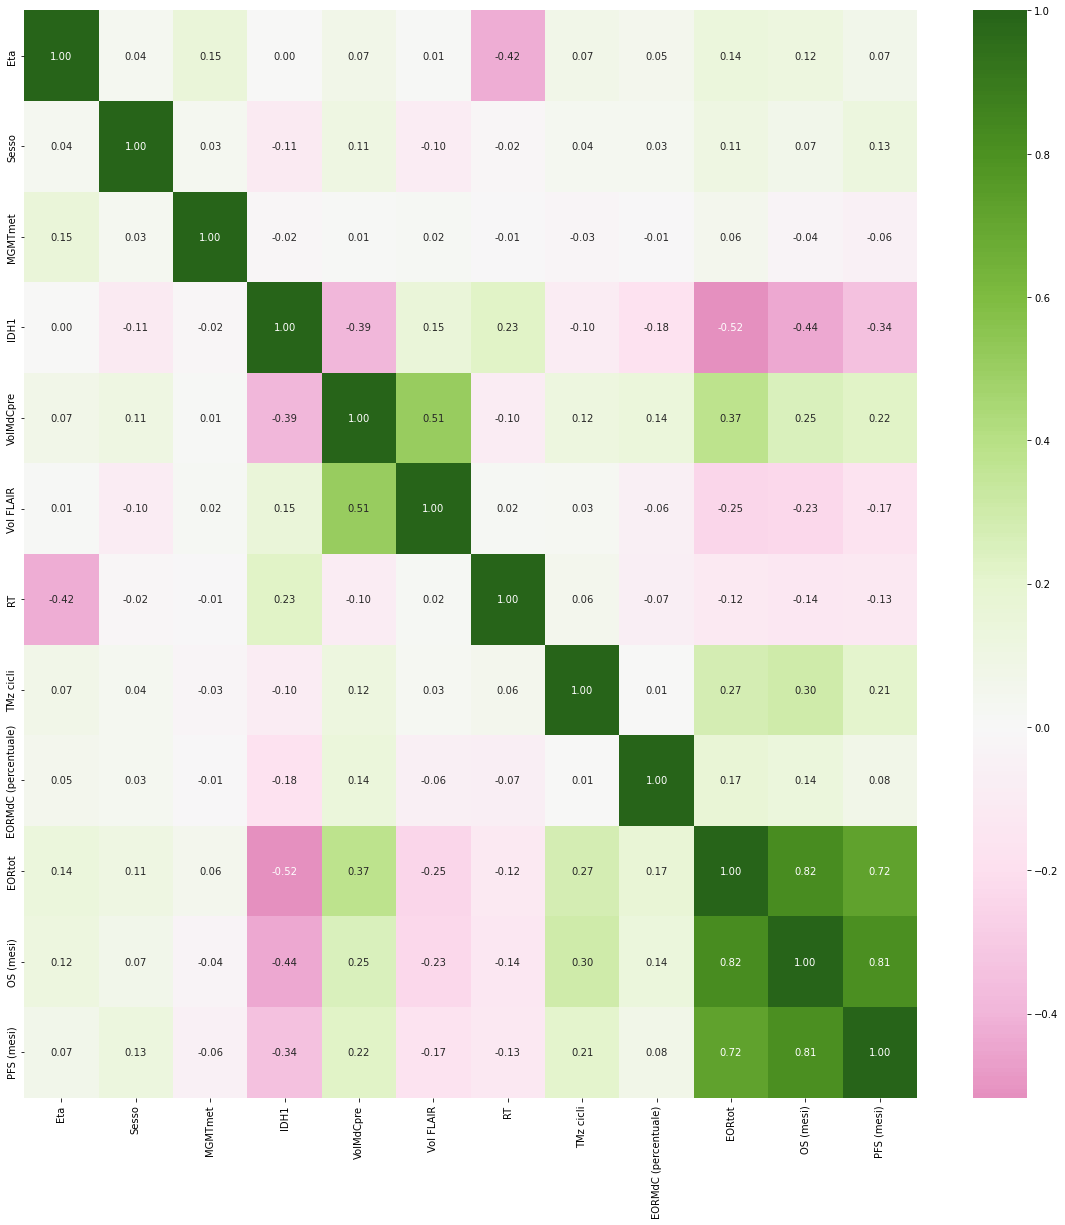

In [4]:
# plot correlation matrix

corr = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2f", center=0, cmap='PiYG')
plt.show()

In order to more effectively apply machine learning algorithms in the future, we need to normalize a few columns.

In [6]:
#normalize data by column
column_excluded = []#['Sesso', 'MGMTmet', 'IDH1']
for column in data.columns:
    if column not in column_excluded:
        data[column] = (data[column] - data[column].mean()) / data[column].std()
data.head()


,Eta,Sesso,MGMTmet,IDH1,VolMdCpre,Vol FLAIR,RT,TMz cicli,EORMdC (percentuale),EORtot,OS (mesi),PFS (mesi)
0,-0.973648,-0.859782,-1.051313,0.848122,0.427323,1.831101,0.321120,-0.085274,-0.360291,-0.686745,-1.042213,-0.686944
1,-0.973648,-0.859782,-1.051313,0.848122,0.291637,1.305539,0.321120,-0.085274,0.231308,0.488303,-0.312542,0.343472
2,-0.641156,-0.859782,-1.051313,0.848122,0.110722,-1.406522,0.321120,-0.085274,0.231308,0.073801,-0.494960,-0.042934
3,1.187552,-0.859782,0.944851,0.848122,1.689613,2.936386,0.321120,-0.085274,-0.300493,-0.746639,-0.859795,-0.944548
4,1.104429,-0.859782,-1.051313,0.848122,-1.270807,-1.099610,-1.558608,-0.085274,0.231308,0.272214,0.052293,-0.171736


Here we can choose 2 columns and plot them against each other.

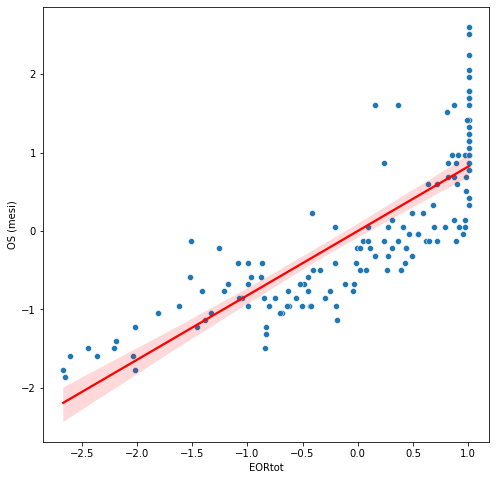

In [7]:
def plot_correlation(column_1, column_2):
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=column_1, y=column_2, data=data)
    # plot line of best fit
    sns.regplot(x=column_1, y=column_2, data=data, scatter=False, color='red')    
    plt.show()
    

# plot_correlation(data[data.columns[-4]], data['OS (mesi)'])
plot_correlation(data['EORtot'], data['OS (mesi)'])

Let's use dimensionality reduction to see if we can find some interesting patterns in the data. This condenses the numerical information of each patient into 2 dimensions so that we can plot it.
We use the first 10 columns as input and the last 2 as color. Thus green means longer than average and red means shorter than average survival time.

In [8]:
# UMAP on data
import umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data.iloc[:, :-2])

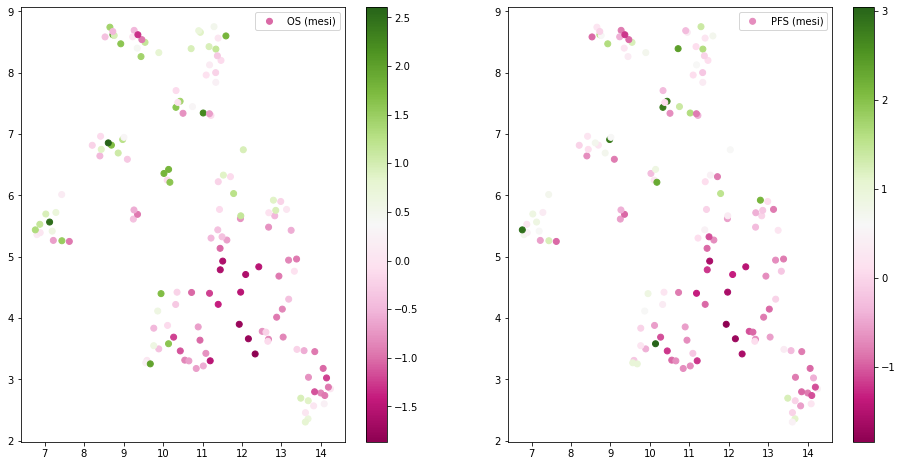

In [9]:
# plot embedding
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(embedding[:, 0], embedding[:, 1], c=data.iloc[:, -2], cmap='PiYG', label=data.columns[-2])
plt.legend()
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(embedding[:, 0], embedding[:, 1], c=data.iloc[:, -1], cmap='PiYG', label=data.columns[-1])
plt.colorbar()
plt.legend()
plt.show()

One can easily see a color gradient: this means that the patients are in principle separable from the data available. Moreover, new patients can be located in this 2D space to predict the survival time.

But we are not done yet. We can also invert the process and identify the most important features that determine the survival time. This is done by using the built in inverse trasform of UMAP.

In [10]:
# #save dataframe 
data.to_csv('data_norm.csv', index=False)

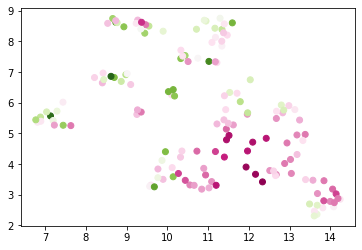

In [11]:
#load dataframe
data = pd.read_csv('data_norm.csv')
labels = data.iloc[:, -2]
mapper = umap.UMAP(random_state=42).fit(data.iloc[:, :-2])

# mapper.embedding_
plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], c=labels, cmap='PiYG')

In [13]:
corners = np.array([
    [7, 5.5],  
    [14, 2.6], 
    [8.65, 8.65],  
    [11.5, 8.65],  
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 5)
    for x in np.linspace(0, 1, 5)
])

In [14]:
inv_transformed_points = mapper.inverse_transform(test_pts)

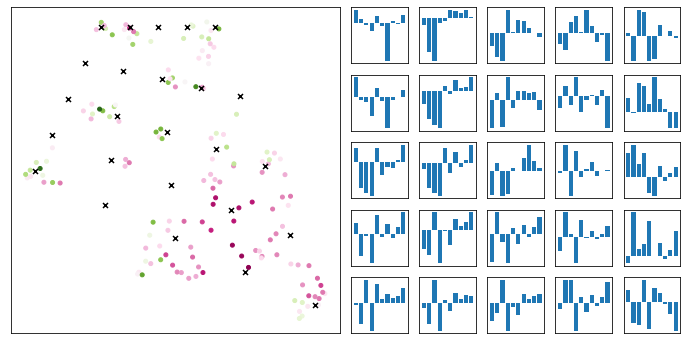

In [15]:
from matplotlib.gridspec import GridSpec
# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(5, 10, fig)
scatter_ax = fig.add_subplot(gs[:, :5])
digit_axes = np.zeros((5, 5), dtype=object)
for i in range(5):
    for j in range(5):
        digit_axes[i, j] = fig.add_subplot(gs[i, 5 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], c=labels, cmap='PiYG', s=16)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=25)

# Plot each of the generated digit images
for i in range(5):
    for j in range(5):
        digit_axes[i, j].bar(range(len(inv_transformed_points[i*5 + j])), inv_transformed_points[i*5 + j])
        digit_axes[i, j].set(xticks=[], yticks=[])

To play around with this, you can use the app.py file in this repository. It is a simple streamlit app that allows to click on this 2D space and get the original features of the patient.

Let's now create a neural network model to try and fit the data.

In [64]:
import torch
import torch.nn as nn

L_SIZE = 5
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.fc1 = nn.Linear(10, L_SIZE)
        self.fc2 = nn.Linear(L_SIZE, L_SIZE)
        self.fc3 = nn.Linear(L_SIZE, L_SIZE)
        self.fc4 = nn.Linear(L_SIZE, L_SIZE)
        self.fc5 = nn.Linear(L_SIZE, L_SIZE)
        self.fc6 = nn.Linear(L_SIZE, L_SIZE)
        self.fc7 = nn.Linear(L_SIZE, 1)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        # x = self.fc4(x)
        # x = self.relu(x)
        # x = self.fc5(x)
        # x = self.relu(x)
        # x = self.fc6(x)
        # x = self.relu(x)
        x = self.fc7(x)
        # x = self.sigmoid(x)
        
        return x
    def train_model(self, train_loader, test_loader, epochs=100, lr=0.001, PLOT_INTERVAL=150):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_losses = []
        test_losses = []
        for epoch in range(epochs):
            for i, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs).view(-1,1)
                loss = criterion(outputs, labels)
                loss.backward()
                train_losses.append(loss.item())
                optimizer.step()
            with torch.no_grad():
                for j, (inputs, labels) in enumerate(test_loader):
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self(inputs).view(-1,1)
                    test_loss = criterion(outputs, labels)
                    test_losses.append(test_loss.item())
            if((epoch % PLOT_INTERVAL == 0 and epoch!=0) or epoch == epochs-1):
                print('Epoch: {}, Train Loss: {:.4f}'.format(epoch, loss.item()))
                print('Epoch: {}, Test Loss: {:.4f}'.format(epoch, test_loss.item()))
                plt.figure(figsize=(8,8))
                plt.plot(train_losses)
                plt.plot(test_losses)
                plt.legend(['train loss', 'test loss'])
                plt.show()
        print('Finished Training')

The model need a dataset class to work with.

In [56]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.Tensor([self.data.iloc[idx, :-2]]), torch.Tensor([self.data.iloc[idx, -1]])
    def train_test_split(self, test_size=0.2):
        train_data = self.data.sample(frac=1-test_size, random_state=0)
        test_data = self.data.drop(train_data.index)
        return train_data, test_data

Now we split data into training and test sets.

In [57]:
# torch.Tensor([data.iloc[1, :-1].values]).to('cuda:0')
dataset = CustomDataset(data)
train_data, test_data = dataset.train_test_split()
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

And we define the Dataloaders.

In [58]:
# import dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=150, shuffle=False)


We are now ready to train the model.

Epoch: 599, Train Loss: 0.3261
Epoch: 599, Test Loss: 0.9119


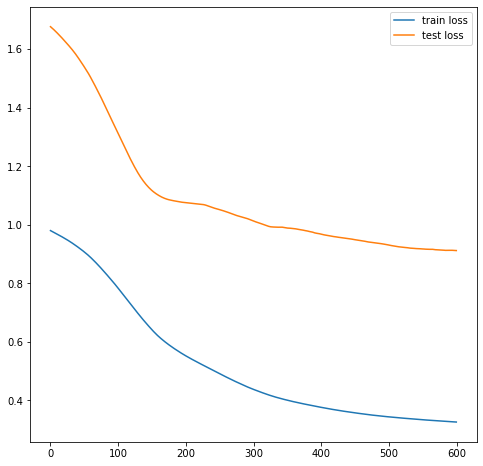

Finished Training


In [66]:
model = Net()
model.train_model(train_loader, test_loader, epochs=600, lr=0.001, PLOT_INTERVAL=2000)

#save model state_dict
# torch.save(model.state_dict(), 'model.pth')

Let's try a clustering algorithm. (To do...)

In [15]:
# kmeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data.iloc[:, :-1]) # careful with the last column